# Getting Started

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/teamspace/studios/this_studio/MAI_DUL_WS24'

In [2]:
# install latest version deepul package
!pip install -e .

Obtaining file:///teamspace/studios/this_studio/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///teamspace/studios/this_studio/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


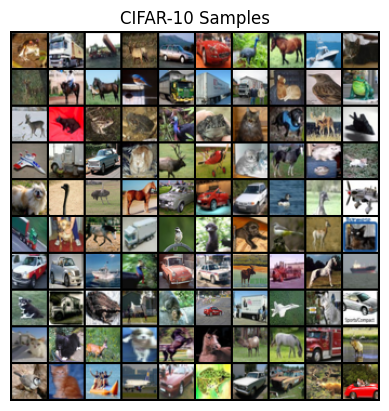

In [4]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [5]:
import torch
import torch.optim as optim
import numpy as np
import math

from torch.utils.data import DataLoader, TensorDataset
from homeworks.hw4.model import UNet
from tqdm.notebook import tqdm

In [6]:
def get_scheduler(optimizer, warmup_steps=100, max_steps=None):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, max_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [7]:
def get_noise_schedule(t):
    """Compute alpha_t and sigma_t using cosine schedule"""
    alpha_t = torch.cos(math.pi * t / 2)
    sigma_t = torch.sin(math.pi * t / 2)
    return alpha_t, sigma_t

In [8]:
def ddpm_update(x, eps_hat, t, t_prev):
    """Perform single DDPM update step"""
    alpha_t, sigma_t = get_noise_schedule(t)
    alpha_prev, sigma_prev = get_noise_schedule(t_prev)
    
    # Compute eta_t according to DDPM formula
    eta_t = (sigma_prev / sigma_t) * torch.sqrt(1 - (alpha_t**2 / alpha_prev**2))
    
    # Compute predicted x0 (clipped to [-1, 1])
    x0_pred = torch.clamp((x - sigma_t * eps_hat) / alpha_t, -1, 1)
    
    # Compute variance term (clip to avoid numerical issues)
    var_term = torch.clamp(sigma_prev**2 - eta_t**2, min=0)
    
    # Sample noise
    epsilon = torch.randn_like(x)
    
    # Compute next x
    x_prev = alpha_prev * x0_pred + torch.sqrt(var_term) * eps_hat + eta_t * epsilon
    
    return x_prev

In [9]:
def sample_diffusion(model, num_samples, num_steps, img_size=32, device='cuda'):
    """Sample from the diffusion model using DDPM"""
    model.eval()
    
    # Initialize from normal distribution
    x = torch.randn(num_samples, 3, img_size, img_size).to(device)
    
    # Create timesteps
    ts = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1).to(device)
    
    with torch.no_grad():
        for i in range(num_steps):
            t = ts[i]
            t_prev = ts[i + 1]
            
            # Get noise prediction
            eps_hat = model(x, t.expand(num_samples))
            
            # Update x
            x = ddpm_update(x, eps_hat, t, t_prev)
    
    return x

In [10]:
def train_epoch(model, train_loader, optimizer, scheduler, device):
    """
    Train the model for one epoch.
    """
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, unit='batch')
    
    for batch_id, batch in enumerate(pbar):
        x = batch[0].to(device)
        
        # Sample t and noise
        t = torch.rand(x.size(0)).to(device)
        epsilon = torch.randn_like(x)
        
        # Forward process
        alpha_t, sigma_t = get_noise_schedule(t)
        alpha_t = alpha_t.view(-1, 1, 1, 1)
        sigma_t = sigma_t.view(-1, 1, 1, 1)
        x_t = alpha_t * x + sigma_t * epsilon
        
        # Predict noise
        epsilon_pred = model(x_t, t)
        
        # Compute loss
        loss = torch.mean((epsilon - epsilon_pred) ** 2)
        
        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())
        
        pbar.set_description(desc=f"Batch loss={loss:.4f}")
        # break
    
    return train_losses

In [11]:
def evaluate_loss(model, loader, device):
    """
    Evaluate model loss on given data loader.
    """
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)
            
            # Sample t and noise
            t = torch.rand(x.size(0)).to(device)
            epsilon = torch.randn_like(x)
            
            # Forward process
            alpha_t, sigma_t = get_noise_schedule(t)
            alpha_t = alpha_t.view(-1, 1, 1, 1)
            sigma_t = sigma_t.view(-1, 1, 1, 1)
            x_t = alpha_t * x + sigma_t * epsilon
            
            # Predict noise
            epsilon_pred = model(x_t, t)
            
            # Compute loss
            loss = torch.mean((epsilon - epsilon_pred) ** 2)
            total_loss += loss.item()

            # break
    
    return total_loss / len(loader)

In [12]:
def generate_samples(model, num_samples_per_row=10, device='cuda'):
    """
    Generate samples from the trained model with different numbers of steps.
    """
    step_range = np.power(2, np.linspace(0, 9, 10)).astype(int)
    samples = []
    
    for num_steps in step_range:
        row_samples = sample_diffusion(model, num_samples_per_row, num_steps, device=device)
        # Transform from [-1, 1] to [0, 1]
        row_samples = (row_samples + 1) / 2
        row_samples = torch.clamp(row_samples, 0, 1)
        row_samples = row_samples.permute(0, 2, 3, 1)
        samples.append(row_samples)
        # break
    
    samples = torch.stack(samples).cpu().numpy()

    return samples

In [13]:
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")
    print(f"Using device: {device}")
    
    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else \
            {'num_workers': 8} if torch.backends.mps.is_available() else \
            {}
    
    # Hyperparameters
    hidden_dim = [64, 128, 256, 512]
    num_epochs = 60
    batch_size = 256
    learning_rate = 1e-3

    # Normalize data to [-1, 1]
    train_data = train_data * 2 - 1
    test_data = test_data * 2 - 1
    
    # Convert to PyTorch tensors
    train_tensor = torch.FloatTensor(train_data).permute(0, 3, 1, 2)
    test_tensor = torch.FloatTensor(test_data).permute(0, 3, 1, 2)

    # Create data loaders
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, **kwargs)
    
    # Initialize model and optimizer
    model = UNet(in_channels=3, hidden_dims=hidden_dim, blocks_per_dim=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Setup scheduler
    total_steps = len(train_loader) * num_epochs
    scheduler = get_scheduler(optimizer, warmup_steps=100, max_steps=total_steps)

    
    # Training
    train_losses = []
    test_losses = [evaluate_loss(model, test_loader, device)]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        # Train one epoch
        epoch_losses = train_epoch(model, train_loader, optimizer, scheduler, device)
        train_losses.extend(epoch_losses)
        
        # Evaluate test loss
        test_loss = evaluate_loss(model, test_loader, device)
        test_losses.append(test_loss)

        # break

    # Generate samples
    samples = generate_samples(model, num_samples_per_row=10, device=device)

    return np.array(train_losses), np.array(test_losses), samples

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda
Epoch 1/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 2/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 3/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 4/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 5/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 6/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 7/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 8/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 9/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 10/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 11/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 12/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 13/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 14/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 15/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 16/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 17/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 18/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 19/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 20/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 21/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 22/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 23/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 24/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 25/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 26/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 27/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 28/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 29/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 30/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 31/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 32/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 33/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 34/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 35/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 36/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 37/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 38/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 39/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 40/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 41/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 42/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 43/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 44/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 45/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 46/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 47/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 48/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 49/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 50/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 51/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 52/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 53/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 54/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 55/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 56/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 57/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 58/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 59/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 60/60


  0%|          | 0/196 [00:00<?, ?batch/s]

Final Test Loss: 0.0617


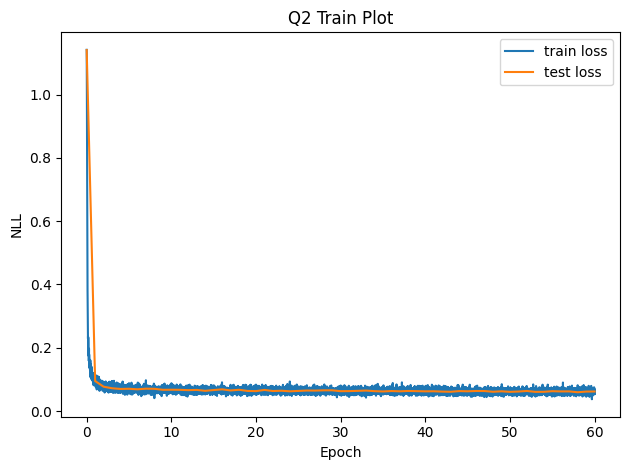

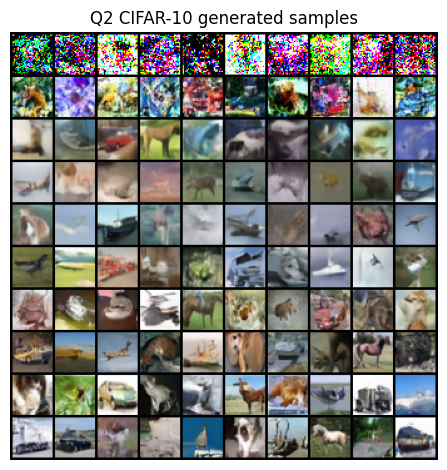

In [14]:
q2_save_results(q2)